In [1]:
#%matplotlib inline

In [2]:
#!pip install torch


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

#for f in fm.fontManager.ttflist:
#   print(f.name)
#for f in fm.fontManager.afmlist:
#   print(f.name)

#!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
#mpl.font_manager.fontManager.addfont('times.ttf')
#mpl.rc('font', family='Times')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from google.colab import drive
# drive.mount('/content/drive') # This is for Google Collab
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:

epochs=100
batch_size = 50


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



torch.Size([50, 3, 32, 32])


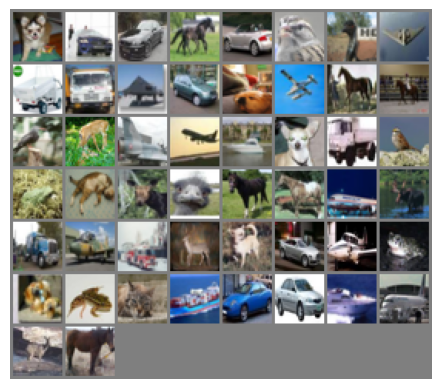

dog   car   car   horse car   bird  bird  plane truck truck plane car   dog   plane horse horse bird  deer  plane plane ship  dog   truck bird  frog  cat   deer  bird  horse horse plane deer  truck plane truck deer  dog   car   plane frog  dog   frog  cat   ship  car   car   ship  plane deer  horse


In [5]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.savefig('Data/images_CIFAR10.pdf')


    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:


#Conv2d(in_channels, out_channels, kernel_size)
#Linear(in_features, out_features)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 2 * 2 , 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        #print("input: ", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("1st conv: ", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("2nd conv: ", x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print("3rd conv: ", x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("1st dense: ", x.shape)
        x = F.relu(self.fc1(x))
        #print("2nd dense: ", x.shape)
        x = F.relu(self.fc2(x))
        #print("3rd dense: ", x.shape)
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:


criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:

losses=torch.zeros(epochs)
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()/labels.size(0)
    print("Epoch ", epoch+1, " Running loss ",running_loss)
    losses[epoch]=running_loss/i

print('Finished Training')

Epoch  1  Running loss  30.439277499914166
Epoch  2  Running loss  22.451979482173904
Epoch  3  Running loss  18.455080747008285
Epoch  4  Running loss  15.702627664208404
Epoch  5  Running loss  13.711446053385709
Epoch  6  Running loss  12.09449992299079
Epoch  7  Running loss  10.7185851714015
Epoch  8  Running loss  9.617078618705284
Epoch  9  Running loss  8.4415977294743
Epoch  10  Running loss  7.464503224194048
Epoch  11  Running loss  6.582226162031292
Epoch  12  Running loss  5.807449036836617
Epoch  13  Running loss  5.170918430536995
Epoch  14  Running loss  4.659173991829161
Epoch  15  Running loss  4.1710214304924005
Epoch  16  Running loss  3.756639094911513
Epoch  17  Running loss  3.4597785087674846
Epoch  18  Running loss  3.1296409238502334
Epoch  19  Running loss  2.833404269181192
Epoch  20  Running loss  2.7227147800289093
Epoch  21  Running loss  2.681295644445346
Epoch  22  Running loss  2.413070090888069
Epoch  23  Running loss  2.2656124846590675
Epoch  24  Ru

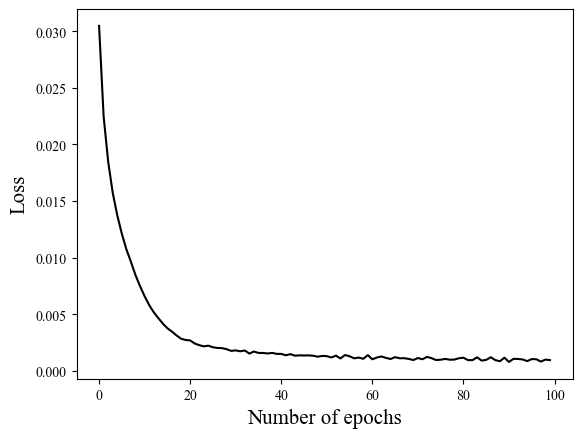

In [9]:

plt.plot(losses,color='black')
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.savefig('Data/loss_CIFAR10.pdf')
plt.show()

Let's quickly save our trained model:



In [10]:
PATH = 'models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



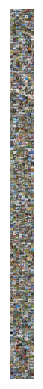

GroundTruth:  cat   ship  ship  plane


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

C:\Users\aswathyr\AppData\Local\Temp\ipykernel_36684\238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %


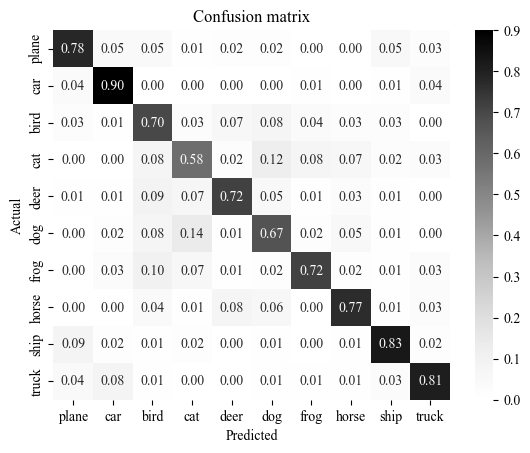

In [17]:



cm=confusion_matrix(predicted,labels)
#classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True,
            fmt='.2f', xticklabels=classes, cbar=True, yticklabels=classes,cmap='Greys')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Data/confusion_cnn_.pdf')
plt.show()


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
batch_size = 50


# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 77.1 %
Accuracy for class: car   is 80.9 %
Accuracy for class: bird  is 63.5 %
Accuracy for class: cat   is 53.7 %
Accuracy for class: deer  is 68.9 %
Accuracy for class: dog   is 63.8 %
Accuracy for class: frog  is 83.1 %
Accuracy for class: horse is 78.4 %
Accuracy for class: ship  is 82.4 %
Accuracy for class: truck is 84.7 %
